# Introduction

In this notebook, we attempt to determine the "best" neighborhood in Pittsburgh. In order to make this determination, we decided to try and find the safest neighborhood in Pittsburgh, which we believe is an important metric for anyone who wants to live or rent in the Pittsburgh area. We also considered the "greenest" neighborhood in Pittsburgh, but determined that there was insufficient data available on the WPRDC website to meaningfully evaluate this.

# The Metric

In order to measure our overall metric of safety, we combined the sub-metrics of number of the arrests per neighborhood taken from WPRDC's [Pittsburgh Police Arrest Data](https://data.wprdc.org/dataset/arrest-data) dataset and the number of police incidents per neighborhood taken from WPRDC's [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter) dataset -- both standardized to the same 30-day timeframe -- in order to make a data-driven determination of the safest neighborhood in Pittsburgh.

# The Best Neighborhood

We performed the following data analysis steps to determine the safest neighorhood in Pittsburgh. First, we will import the necessary Python packages:

In [99]:
# import packages

#!pip install geopandas
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

Next, we will import and process the datasets:

In [100]:
# read in dataset and parse dates as DateTime objects
arrests = pd.read_csv("police_arrest_data.csv", parse_dates=["ARRESTTIME"])

# drop observations that have null values in the INCIDENTNEIGHBORHOOD column
arrests = arrests.dropna(subset=['INCIDENTNEIGHBORHOOD'])

# filter arrests data to dates consistent with the other, 30-day dataframe
start_date = pd.to_datetime('2023-03-10')
end_date = pd.to_datetime('2023-04-06')

filtered_arrests = arrests[(arrests['ARRESTTIME'] >= start_date) & (arrests['ARRESTTIME'] <= end_date)]

In [101]:
# read in dataset
blotter = pd.read_csv("police_incident_blotter_data.csv")

# drop observations that have null values in the INCIDENTNEIGHBORHOOD column
blotter = blotter.dropna(subset=['INCIDENTNEIGHBORHOOD'])

Determining the number of arrests per neighborhood is a straightforward `count()`ing operation:

In [102]:
# count the number of arrests per neighborhood
num_arrests = filtered_arrests.groupby("INCIDENTNEIGHBORHOOD").count()["OFFENSES"].sort_values(ascending=True)

However, each incident in the `blotter` dataset has a `HIERARCHY` value associated with it, with more severe incidents having a higher `HIERARCHY` value. For example, a parking violation has a very low `HIERARCHY` value, while a missing person report has a very high `HIERARCHY` value. Thus, we sum the `HIERARCHY` values within each neighborhood to get a more nuanced measure of neighborhood safety than the raw number of incidents.

In [103]:
# sum the hierarchy of all the events for each neighborhood
rank = blotter.groupby("INCIDENTNEIGHBORHOOD").sum()['HIERARCHY'].sort_values(ascending=True)

We can now plot each sub-metric:

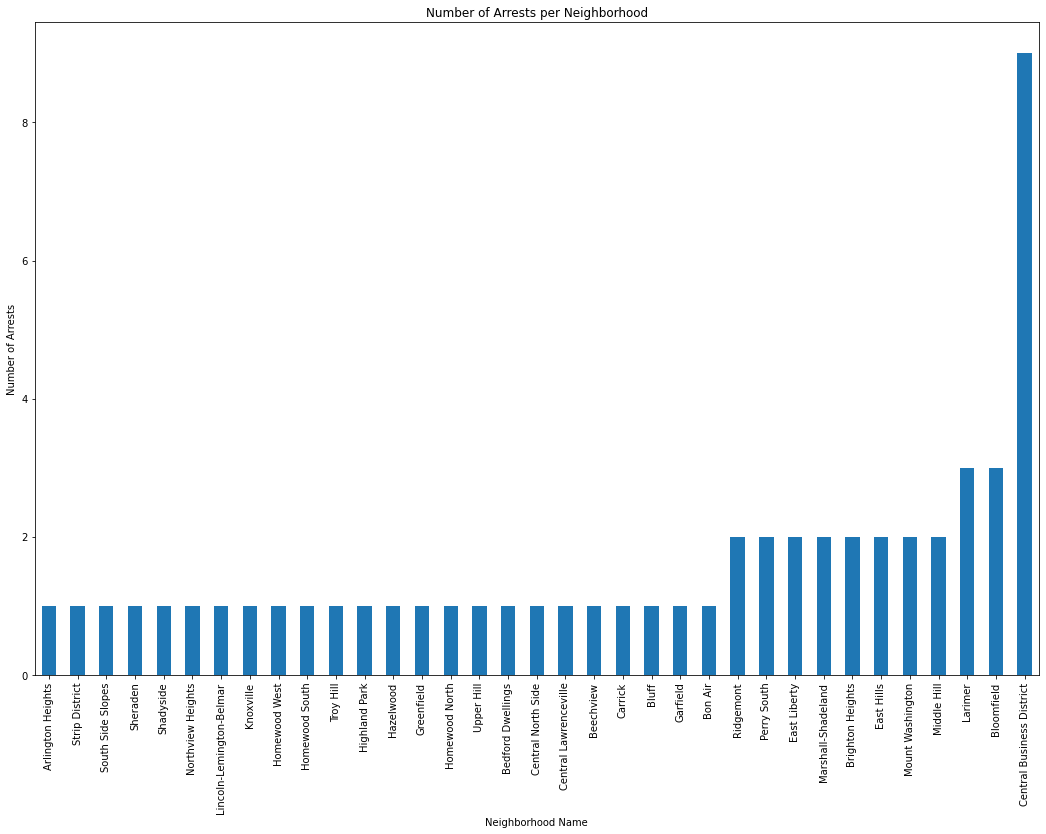

In [104]:
# create a bar plot
ax = num_arrests.plot.bar(figsize=(18, 12))

# add titles and labels
ax.set_title('Number of Arrests per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Number of Arrests')

# angle neighborhood labels
plt.xticks(rotation=90)

# show the plot
plt.show()

We can also create a choropleth map of the results:

<AxesSubplot:>

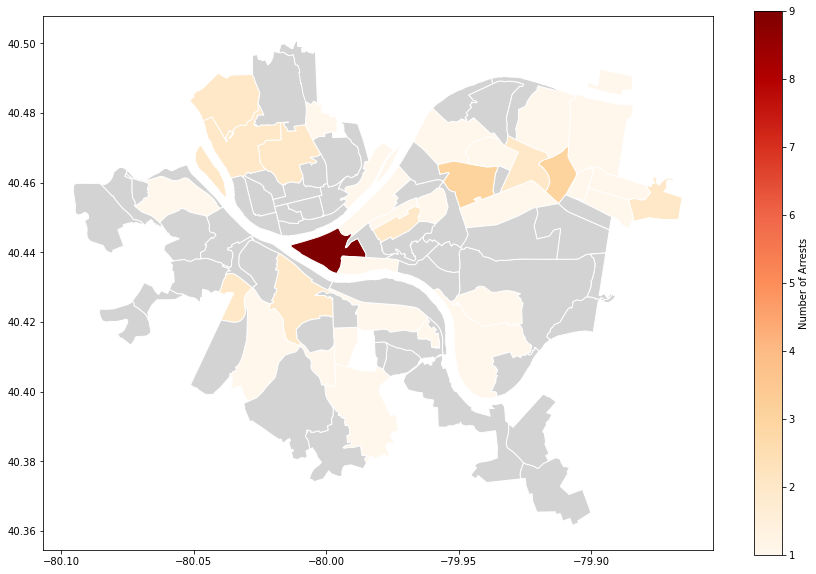

In [105]:
# create a geopandas map
import geopandas

# read in the shapefile
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# do the merge
arrests_map = neighborhoods.merge(num_arrests, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

# draw a choropleth map using data from the column named "OFFENSES"
arrests_map.plot(column='OFFENSES', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Arrests"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

These graphs show that, within the 30-day timeframe consistent with the `blotter` dataset, there are many neighborhoods tied with having zero, one, or two arrests, and so we will need to augment our results with more data in order to draw any meaningful conclusions.

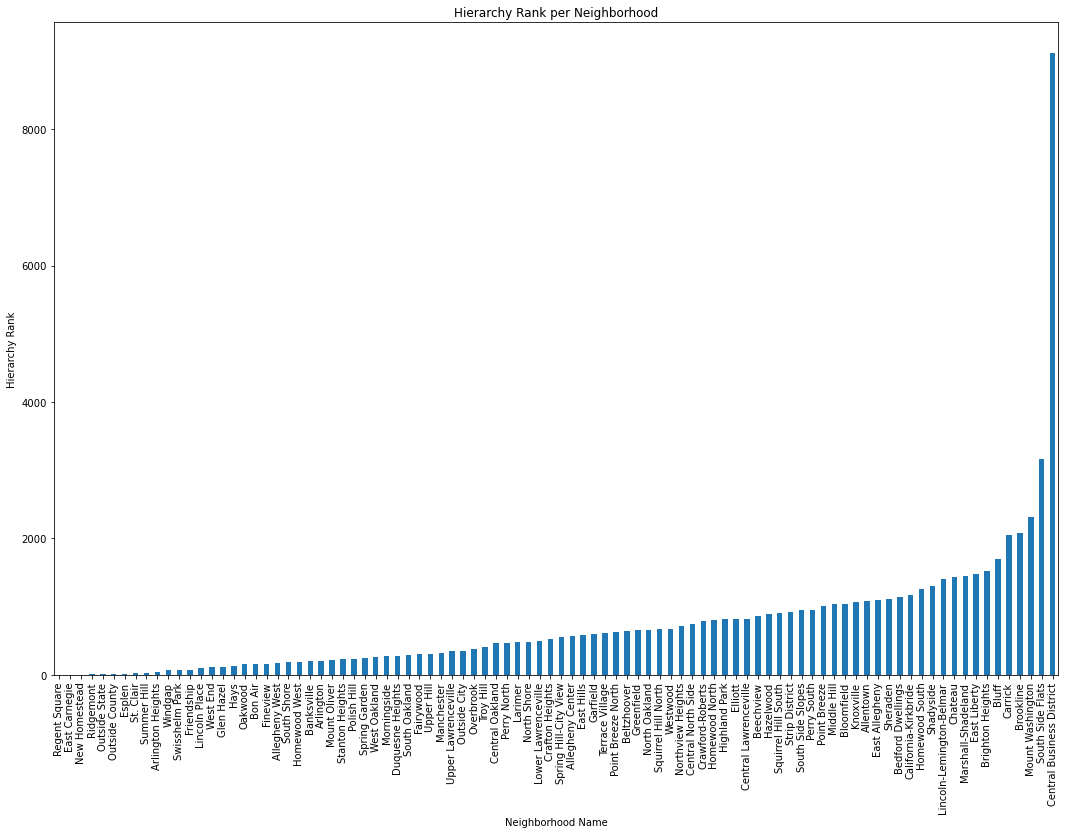

In [106]:
# create a bar plot
ax = rank.plot.bar(figsize = (18, 12))

# add titles and labels
ax.set_title('Hierarchy Rank per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Hierarchy Rank')

# angle neighborhood labels
plt.xticks(rotation=90)

# show the plot
plt.show()

Whoa! This is a large bar graph. Perhaps a choropleth map will be a more interpretable visualization?

<AxesSubplot:>

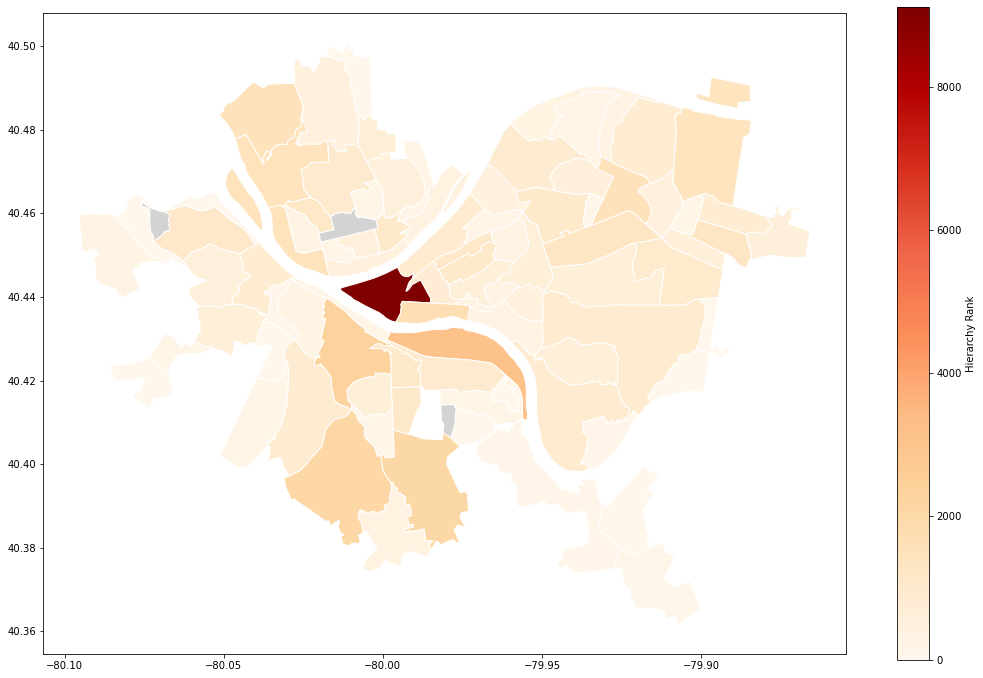

In [107]:
# do the merge
rank_map = neighborhoods.merge(rank, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

# draw a choropleth map using data from the column named "HIERARCHY"
rank_map.plot(column='HIERARCHY', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Hierarchy Rank"}, # label the legend
               figsize=(18, 12),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

From the above two chloropleth maps, we can see that the `Central Business District` has the highest crime rate both in terms of arrests and number of incidents.

We can also plot both sub-metrics on the same graph, but due to the vastly different scales of the sub-metrics this is not a particularly useful visualization.

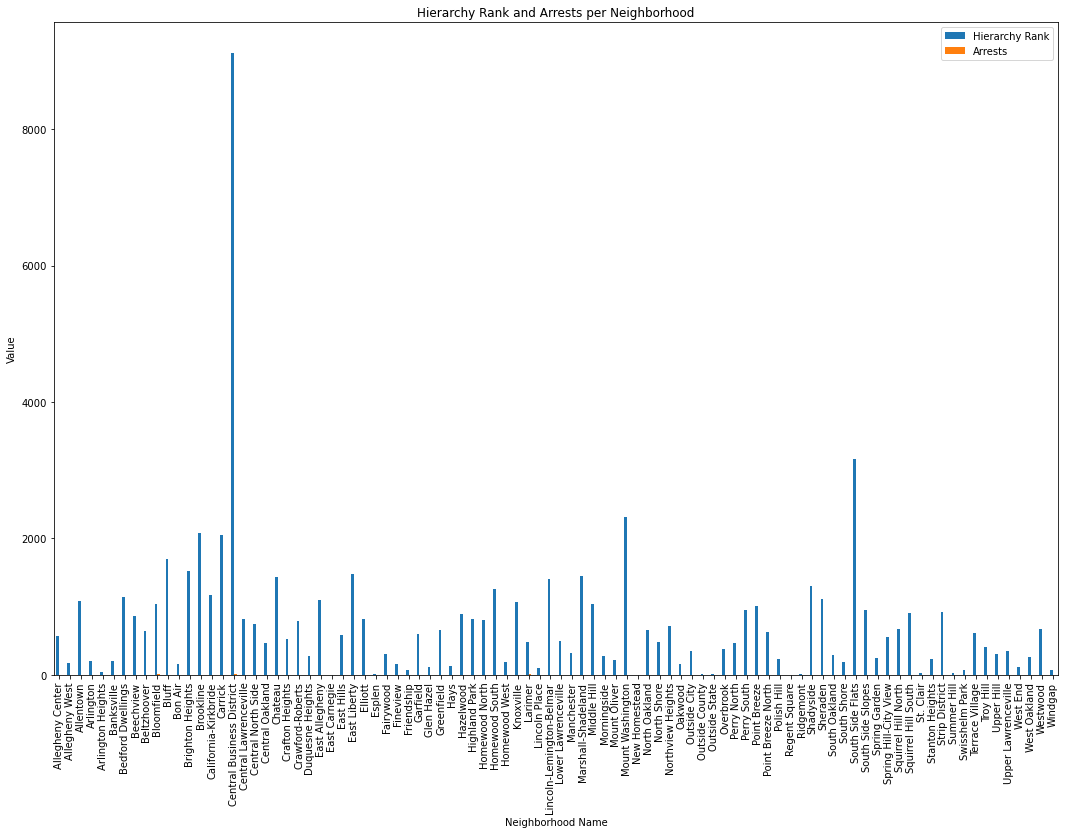

In [108]:
# combine both sub-metrics into a single dataframe
df = pd.DataFrame({'Hierarchy Rank': rank, 'Arrests': num_arrests})

# create a bar plot
ax = df.plot.bar(figsize = (18, 12))

# add titles and labels
ax.set_title('Hierarchy Rank and Arrests per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Value')

# show the plot
plt.show()

As such, we will manually compare the two sub-metrics in order to find the safest neighborhood:

In [109]:
num_arrests

INCIDENTNEIGHBORHOOD
Arlington Heights            1
Strip District               1
South Side Slopes            1
Sheraden                     1
Shadyside                    1
Northview Heights            1
Lincoln-Lemington-Belmar     1
Knoxville                    1
Homewood West                1
Homewood South               1
Troy Hill                    1
Highland Park                1
Hazelwood                    1
Greenfield                   1
Homewood North               1
Upper Hill                   1
Bedford Dwellings            1
Central North Side           1
Central Lawrenceville        1
Beechview                    1
Carrick                      1
Bluff                        1
Garfield                     1
Bon Air                      1
Ridgemont                    2
Perry South                  2
East Liberty                 2
Marshall-Shadeland           2
Brighton Heights             2
East Hills                   2
Mount Washington             2
Middle Hill       

In [110]:
rank.head(20)

INCIDENTNEIGHBORHOOD
Regent Square          0
East Carnegie          0
New Homestead          0
Ridgemont              6
Outside State         12
Outside County        13
Esplen                13
St. Clair             25
Summer Hill           30
Arlington Heights     34
Windgap               64
Swisshelm Park        66
Friendship            73
Lincoln Place         96
West End             119
Glen Hazel           119
Hays                 127
Oakwood              153
Bon Air              153
Fineview             156
Name: HIERARCHY, dtype: int64

# Individual Conclusions

Vivek: I was unable to draw any meaningful conclusions from my dataset due to the small amount of data in the subsetted timeframe. However, my brother used to live in Shadyside, so it's encouraging to see that the neighborhood has a low arrest rate.

Connie: The data driven determination of “best neighborhood” is different from my personal favorite neighborhoods. I honestly haven not been to any of the places listed above or have been to some of them without realizing it. As I spend most of my time on campus and the neighborhood I live in, I would say Central Oakland is safe for me, as a place with a high flow of people everyday. I believe Squirrel Hill is also relatively safe. On the other hand, the "safe" neighborhoods listed above might only be "safe" because the population there is relatively small.

# Overall Conclusion

Ideally, we would want the populations of each neighborhood in order to create a metric such as number of arrests/police incidents per thousand people. We would also want data going back further than the most recent 30 days. However, barring this, the neighborhoods of Regent Square, East Carnegie, and New Homestead all had zero police incidents and zero arrests in the past 30 days, suggesting that they are nevertheless very safe. Among these, we are most familiar with Regent Square as it is relatively close to campus, and is also where Vivek's scholar-mentor in the Frederick Honors College, Dr. Aidan Beatty, lives. As such, we choose **Regent Square** as our overall safest/best neighborhood for this project.